In [1]:
import torch 
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from data_processing.ScanObjectNN import ScanObjectNNDataset
from train_functions.ScanObject_training import train_scanobject
from cloud_transformer.classification_model import CT_Classifier

from data_processing.ModelNet40 import ModelNetDataset
from train_functions.ModelNet40_training import train_modelnet40

from data_processing.ShapeNet import ShapeNetCompletionDataset
from cloud_transformer.completion_model import CT_Completion
from train_functions.ShapeNet_training import train_shapenet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print("Device: ", device)
%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Device:  cuda


## Original Cloud Transformers 

### Classification : 


#### ModelNet40 

In [3]:
# File paths
root = "data/ModelNet40_PLY"

# Loading datasets + online data augmentation
train_ds = ModelNetDataset(root, folder="train", rotate=True, noise=True)
test_ds  = ModelNetDataset(root, folder="test")

# DataLoaders 
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=8, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=8, pin_memory=True)

# input : (B, N, 3)
model_modelnet = CT_Classifier(n_classes=40, model_dim=256, heads=8, num_layers=2, dropout=0.5, use_scales=True , use_checkpoint=False)

load = True 
if load : 
    model_modelnet.load_state_dict(torch.load("saved_models/ct_classifier_modelnet.pth", map_location=device))
    print(f"✅ Model Loaded")
    
model_modelnet.to(device)

best_model = train_modelnet40(model_modelnet, device, train_loader, test_loader, epochs=5, lr=0.0001, weight_decay=0, eval_mode=False) # Eval mode to evaluate test_loader once with the loaded model

save = True 
if save : 
    save_path = "saved_models/ct_classifier_modelnet.pth"
    torch.save(best_model.state_dict(), save_path)
    print(f"✅ Model saved to {save_path}")

✅ Model Loaded


[Eval] Val Loss: 0.3689, Acc: 88.65%


Epoch 1/5 — Train Loss: 0.1885 | Val Loss: 0.3601, Acc: 89.34%


Epoch 2/5 — Train Loss: 0.1792 | Val Loss: 0.3698, Acc: 88.53%


Epoch 3/5 — Train Loss: 0.1764 | Val Loss: 0.3693, Acc: 88.90%


Epoch 4/5 — Train Loss: 0.1669 | Val Loss: 0.3662, Acc: 89.22%


Epoch 5/5 — Train Loss: 0.1588 | Val Loss: 0.3706, Acc: 89.30%
✅ Model saved to saved_models/ct_classifier_modelnet.pth


#### ScanObjectNN

In [2]:
# File paths
train_path = 'data/h5_files/main_split/training_objectdataset_augmentedrot_scale75.h5'
test_path  = 'data/h5_files/main_split/test_objectdataset_augmentedrot_scale75.h5'

# Loading Datasets
train_ds = ScanObjectNNDataset(train_path, rotate=True, noise=True)
test_ds  = ScanObjectNNDataset(test_path)

# DataLoaders — Online Data Augmentation
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=8)
test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=8)


model_scanobject = CT_Classifier(n_classes=15, model_dim=256, heads=8, num_layers=2, dropout=0.5, use_scales=True , use_checkpoint=False)

load = True 
if load : 
    model_scanobject.load_state_dict(torch.load("saved_models/ct_classifier_scanobject.pth", map_location=device))
    print(f"✅ Model Loaded")

model_scanobject.to(device)
best_model = train_scanobject(model_scanobject, device, train_loader, test_loader, epochs=5, lr=0.0001, weight_decay=0, eval_mode=False)

save = True 
if save : 
    save_path = "saved_models/ct_classifier_scanobject.pth"
    torch.save(best_model.state_dict(), save_path)
    print(f"✅ Model saved to {save_path}")

✅ Model Loaded


[Eval] Loss: 0.5530, Cls Acc: 81.30%, Seg Acc: 79.87%


Epoch 1/5 — Train Loss: 0.3123 | Val Loss: 0.5437, Classif Acc: 82.27%, Segm Acc: 79.73%


Epoch 2/5 — Train Loss: 0.3028 | Val Loss: 0.5647, Classif Acc: 80.71%, Segm Acc: 79.87%


Epoch 3/5 — Train Loss: 0.3050 | Val Loss: 0.5651, Classif Acc: 80.78%, Segm Acc: 79.92%


Epoch 4/5 — Train Loss: 0.2944 | Val Loss: 0.5630, Classif Acc: 81.54%, Segm Acc: 80.08%


Epoch 5/5 — Train Loss: 0.2841 | Val Loss: 0.5625, Classif Acc: 81.23%, Segm Acc: 80.03%
✅ Model saved to saved_models/ct_classifier_scanobject.pth


### Point Completion :

#### ShapeNet

In [2]:
# Shapenet is modifed to only have 1 types of objects instead of 8 (Airplanes only)
root = os.path.join(os.getcwd(), "data", "ShapeNetCompletion")
train_ds = ShapeNetCompletionDataset(root, split='train', n_input=2048, n_output=8192)
test_ds  = ShapeNetCompletionDataset(root, split='test', n_input=2048, n_output=8192)

print(f"Train set size: {len(train_ds)}")
print(f"Test set size:  {len(test_ds)}")

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=4)

# Coarser Grid are used here to speed up training
ct_completion_shapenet = CT_Completion(num_latent=512, model_dim=512, heads=12, num_layers=1, use_scales=False, use_checkpoint=False)

load = True 
if load : 
    ct_completion_shapenet.load_state_dict(torch.load("saved_models/ct_completion_shapenet.pth", map_location=device))
    print(f"✅ Model Loaded")

ct_completion_shapenet.to(device)
best_model = train_shapenet(ct_completion_shapenet, device, train_loader, test_loader, epochs=4, lr=0.00001, weight_decay=0, subsample=1000, eval_mode=False, chamfer_weight=1) 

save = True 
if save : 
    save_path = "saved_models/ct_completion_shapenet.pth"
    torch.save(best_model.state_dict(), save_path)
    print(f"✅ Model saved to {save_path}")

Train set size: 30360
Test set size:  150
✅ Model Loaded


[Eval] mAvg. CD: 6.997 | mAvg. F1@1%: 0.8370


Epoch 1/4 — Train Loss: 0.0243 | mAvg. CD: 6.786 | mAvg. F1@1%: 0.8460


Epoch 2/4 — Train Loss: 0.0240 | mAvg. CD: 6.749 | mAvg. F1@1%: 0.8478


Epoch 3/4 — Train Loss: 0.0241 | mAvg. CD: 6.790 | mAvg. F1@1%: 0.8461


Epoch 4/4 — Train Loss: 0.0238 | mAvg. CD: 6.801 | mAvg. F1@1%: 0.8459
✅ Model saved to saved_models/ct_completion_shapenet.pth


#### Visualization : 

In [ ]:
root = os.path.join(os.getcwd(), "data", "ShapeNetCompletion")
train_ds = ShapeNetCompletionDataset(root, split='train', n_input=2048, n_output=8192)
test_ds  = ShapeNetCompletionDataset(root, split='test', n_input=2048, n_output=8192)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=0)

model = CT_Completion(num_latent=512, model_dim=512, heads=12, num_layers=1, use_scales=False, use_checkpoint=False)
model.load_state_dict(torch.load("saved_models/ct_completion_shapenet.pth", map_location=device))
print(f"✅ Model Loaded")
model = model.to(device)
from data_processing.ShapeNet import visualize_completion
visualize_completion(model, test_loader, device, num_samples=30)

✅ Model Loaded


### Improvement Testing on classification with ModelNet10

#### Soft-max weighted aggregation 

[Eval] Val Loss: 2.3004, Acc: 16.08%


Epoch 1/20 — Train Loss: 0.7385 | Val Loss: 0.7486, Acc: 73.02%


Epoch 2/20 — Train Loss: 0.3851 | Val Loss: 0.4864, Acc: 82.05%


Epoch 3/20 — Train Loss: 0.3169 | Val Loss: 0.5344, Acc: 80.95%


Epoch 4/20 — Train Loss: 0.2580 | Val Loss: 0.3658, Acc: 85.90%


Epoch 5/20 — Train Loss: 0.2581 | Val Loss: 0.3126, Acc: 89.65%


Epoch 6/20 — Train Loss: 0.2289 | Val Loss: 0.3120, Acc: 87.89%


Epoch 7/20 — Train Loss: 0.2086 | Val Loss: 0.3876, Acc: 86.12%


Epoch 8/20 — Train Loss: 0.2149 | Val Loss: 0.3496, Acc: 86.67%


Epoch 9/20 — Train Loss: 0.1627 | Val Loss: 0.2755, Acc: 89.87%


Epoch 10/20 — Train Loss: 0.1433 | Val Loss: 0.2873, Acc: 88.88%


Epoch 11/20 — Train Loss: 0.1326 | Val Loss: 0.2929, Acc: 89.21%


Epoch 12/20 — Train Loss: 0.1090 | Val Loss: 0.2775, Acc: 89.32%


Epoch 13/20 — Train Loss: 0.0953 | Val Loss: 0.2437, Acc: 89.32%


Epoch 14/20 — Train Loss: 0.0979 | Val Loss: 0.2408, Acc: 89.87%


Epoch 15/20 — Train Loss: 0.0931 | Val Loss: 0.2232, Acc: 90.75%


Epoch 16/20 — Train Loss: 0.0888 | Val Loss: 0.2705, Acc: 88.88%


Epoch 17/20 — Train Loss: 0.0908 | Val Loss: 0.2854, Acc: 88.88%


Epoch 18/20 — Train Loss: 0.0812 | Val Loss: 0.2326, Acc: 91.08%


Epoch 19/20 — Train Loss: 0.0749 | Val Loss: 0.2231, Acc: 90.42%


Epoch 20/20 — Train Loss: 0.0693 | Val Loss: 0.2536, Acc: 89.43%


[Eval] Val Loss: 2.3034, Acc: 11.01%


Epoch 1/20 — Train Loss: 0.5981 | Val Loss: 0.4976, Acc: 82.05%


Epoch 2/20 — Train Loss: 0.3026 | Val Loss: 0.4371, Acc: 85.57%


Epoch 3/20 — Train Loss: 0.2177 | Val Loss: 0.4187, Acc: 84.80%


Epoch 4/20 — Train Loss: 0.1918 | Val Loss: 0.3426, Acc: 87.00%


Epoch 5/20 — Train Loss: 0.1660 | Val Loss: 0.2940, Acc: 88.44%


Epoch 6/20 — Train Loss: 0.1617 | Val Loss: 0.3692, Acc: 87.33%


Epoch 7/20 — Train Loss: 0.1301 | Val Loss: 0.2503, Acc: 89.54%


Epoch 8/20 — Train Loss: 0.1384 | Val Loss: 0.3914, Acc: 86.45%


Epoch 9/20 — Train Loss: 0.1370 | Val Loss: 0.2566, Acc: 89.76%


Epoch 10/20 — Train Loss: 0.0996 | Val Loss: 0.2126, Acc: 91.52%


Epoch 11/20 — Train Loss: 0.0875 | Val Loss: 0.2313, Acc: 90.64%


Epoch 12/20 — Train Loss: 0.0843 | Val Loss: 0.2236, Acc: 90.42%


Epoch 13/20 — Train Loss: 0.0678 | Val Loss: 0.2085, Acc: 91.74%


Epoch 14/20 — Train Loss: 0.0526 | Val Loss: 0.2652, Acc: 89.98%


Epoch 15/20 — Train Loss: 0.0515 | Val Loss: 0.2118, Acc: 91.41%


Epoch 16/20 — Train Loss: 0.0506 | Val Loss: 0.1960, Acc: 92.29%


Epoch 17/20 — Train Loss: 0.0465 | Val Loss: 0.1887, Acc: 92.40%


Epoch 18/20 — Train Loss: 0.0432 | Val Loss: 0.2162, Acc: 91.08%


Epoch 19/20 — Train Loss: 0.0371 | Val Loss: 0.2090, Acc: 91.41%


Epoch 20/20 — Train Loss: 0.0393 | Val Loss: 0.2228, Acc: 90.86%


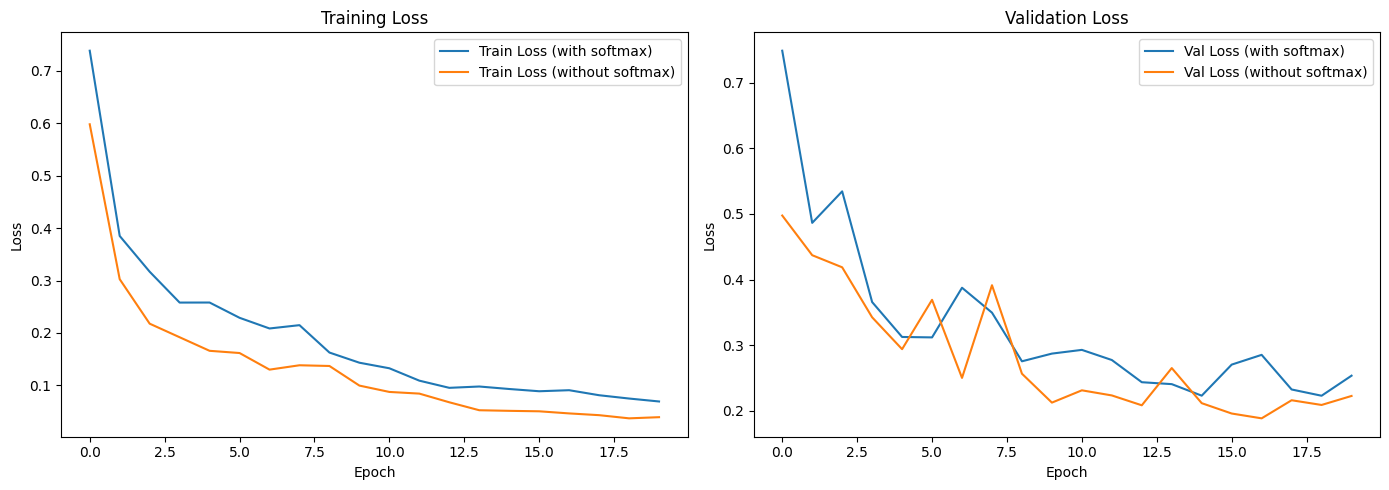

In [ ]:
# File paths
root = "data/ModelNet10_PLY"

# Loading datasets + online data augmentation
train_ds = ModelNetDataset(root, folder="train", rotate=True, noise=True)
test_ds = ModelNetDataset(root, folder="test")

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

for use_softmax in [True, False]:
    model_modelnet = CT_Classifier(n_classes=10, model_dim=256, heads=8, num_layers=2,
                                   dropout=0.5, use_scales=True, use_checkpoint=True,
                                   use_softmax=use_softmax)
    model_modelnet.to(device)

    _, train_loss, val_loss = train_modelnet40(model_modelnet, device, train_loader,
                                               test_loader, epochs=20, lr=0.001,
                                               weight_decay=1e-4, eval_mode=False,
                                               return_loss_history=True)

    label_suffix = "with softmax" if use_softmax else "without softmax"

    axs[0].plot(train_loss, label=f"Train Loss ({label_suffix})")
    axs[1].plot(val_loss, label=f"Val Loss ({label_suffix})")

axs[0].set_title("Training Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].set_title("Validation Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()


#### Scale and Layer Norm

[Eval] Val Loss: 2.3110, Acc: 9.91%


Epoch 1/15 — Train Loss: 0.5144 | Val Loss: 0.4994, Acc: 80.40%


Epoch 2/15 — Train Loss: 0.2508 | Val Loss: 0.4803, Acc: 83.81%


Epoch 3/15 — Train Loss: 0.1988 | Val Loss: 0.2904, Acc: 89.32%


Epoch 4/15 — Train Loss: 0.1984 | Val Loss: 0.3195, Acc: 87.44%


Epoch 5/15 — Train Loss: 0.1831 | Val Loss: 0.3278, Acc: 87.44%


Epoch 6/15 — Train Loss: 0.1200 | Val Loss: 0.2421, Acc: 89.54%


Epoch 7/15 — Train Loss: 0.1092 | Val Loss: 0.2532, Acc: 89.76%


Epoch 8/15 — Train Loss: 0.0919 | Val Loss: 0.2424, Acc: 90.20%


Epoch 9/15 — Train Loss: 0.0834 | Val Loss: 0.2185, Acc: 90.97%


Epoch 10/15 — Train Loss: 0.0767 | Val Loss: 0.2202, Acc: 90.53%


Epoch 11/15 — Train Loss: 0.0738 | Val Loss: 0.2047, Acc: 91.41%


Epoch 12/15 — Train Loss: 0.0640 | Val Loss: 0.2207, Acc: 91.08%


Epoch 13/15 — Train Loss: 0.0626 | Val Loss: 0.2199, Acc: 91.08%


Epoch 14/15 — Train Loss: 0.0535 | Val Loss: 0.2068, Acc: 91.96%


Epoch 15/15 — Train Loss: 0.0530 | Val Loss: 0.2292, Acc: 91.30%


[Eval] Val Loss: 2.3053, Acc: 9.47%


Epoch 1/15 — Train Loss: 0.5707 | Val Loss: 0.4905, Acc: 80.18%


Epoch 2/15 — Train Loss: 0.2845 | Val Loss: 0.3828, Acc: 86.23%


Epoch 3/15 — Train Loss: 0.2235 | Val Loss: 0.4245, Acc: 84.03%


Epoch 4/15 — Train Loss: 0.1901 | Val Loss: 0.4325, Acc: 86.01%


Epoch 5/15 — Train Loss: 0.1631 | Val Loss: 0.2196, Acc: 90.31%


Epoch 6/15 — Train Loss: 0.1155 | Val Loss: 0.2433, Acc: 90.75%


Epoch 7/15 — Train Loss: 0.1121 | Val Loss: 0.2315, Acc: 90.42%


Epoch 8/15 — Train Loss: 0.0946 | Val Loss: 0.2199, Acc: 90.97%


Epoch 9/15 — Train Loss: 0.0847 | Val Loss: 0.2393, Acc: 90.09%


Epoch 10/15 — Train Loss: 0.0759 | Val Loss: 0.2155, Acc: 91.63%


Epoch 11/15 — Train Loss: 0.0678 | Val Loss: 0.2076, Acc: 91.63%


Epoch 12/15 — Train Loss: 0.0636 | Val Loss: 0.1961, Acc: 92.51%


Epoch 13/15 — Train Loss: 0.0591 | Val Loss: 0.2115, Acc: 91.41%


Epoch 14/15 — Train Loss: 0.0587 | Val Loss: 0.2112, Acc: 91.52%


Epoch 15/15 — Train Loss: 0.0527 | Val Loss: 0.2060, Acc: 91.41%


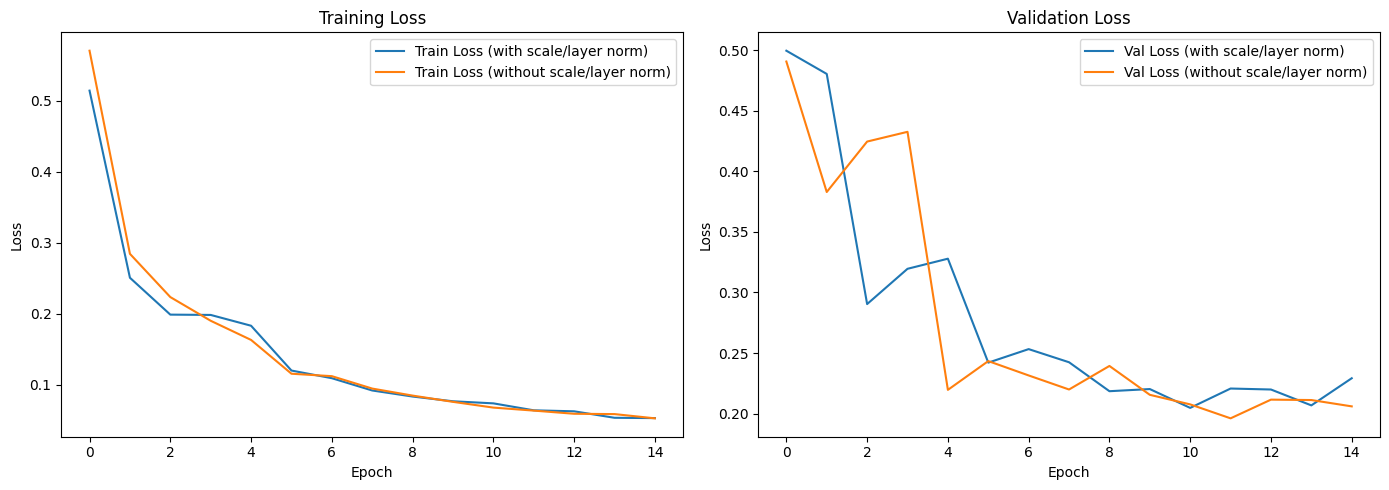

In [2]:
# File paths
root = "data/ModelNet10_PLY"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading datasets + online data augmentation
train_ds = ModelNetDataset(root, folder="train", rotate=True, noise=True)
test_ds = ModelNetDataset(root, folder="test")

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

for norm in [True, False]:
    model_modelnet = CT_Classifier(n_classes=10, model_dim=256, heads=8, num_layers=2,
                                   dropout=0.5, use_scales=True, use_checkpoint=True,
                                   scale_layer_norm=norm)
    model_modelnet.to(device)

    _, train_loss, val_loss = train_modelnet40(model_modelnet, device, train_loader,
                                               test_loader, epochs=15, lr=0.001,
                                               weight_decay=1e-4, eval_mode=False,
                                               return_loss_history=True)

    label_suffix = "with scale/layer norm" if norm else "without scale/layer norm"

    axs[0].plot(train_loss, label=f"Train Loss ({label_suffix})")
    axs[1].plot(val_loss, label=f"Val Loss ({label_suffix})")

axs[0].set_title("Training Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].set_title("Validation Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()


#### Hierarchical Multi-Head Attention

[Eval] Val Loss: 3.6911, Acc: 4.01%


Epoch 1/15 — Train Loss: 1.3170 | Val Loss: 0.8618, Acc: 72.93%


Epoch 2/15 — Train Loss: 0.7885 | Val Loss: 0.7541, Acc: 76.82%


Epoch 3/15 — Train Loss: 0.6765 | Val Loss: 0.6307, Acc: 79.50%


Epoch 4/15 — Train Loss: 0.6065 | Val Loss: 0.5778, Acc: 82.86%


Epoch 5/15 — Train Loss: 0.5778 | Val Loss: 0.5772, Acc: 83.10%


Epoch 6/15 — Train Loss: 0.5381 | Val Loss: 0.5218, Acc: 83.87%


Epoch 7/15 — Train Loss: 0.5168 | Val Loss: 0.5341, Acc: 83.79%


Epoch 8/15 — Train Loss: 0.4719 | Val Loss: 0.4992, Acc: 84.12%


Epoch 9/15 — Train Loss: 0.4471 | Val Loss: 0.4754, Acc: 85.37%


Epoch 10/15 — Train Loss: 0.4308 | Val Loss: 0.5597, Acc: 82.90%


Epoch 11/15 — Train Loss: 0.4203 | Val Loss: 0.4524, Acc: 86.18%


Epoch 12/15 — Train Loss: 0.4074 | Val Loss: 0.4700, Acc: 85.25%


Epoch 13/15 — Train Loss: 0.3894 | Val Loss: 0.4655, Acc: 85.25%


Epoch 14/15 — Train Loss: 0.3111 | Val Loss: 0.4016, Acc: 87.84%


Epoch 15/15 — Train Loss: 0.2785 | Val Loss: 0.4232, Acc: 87.28%


[Eval] Val Loss: 3.6871, Acc: 0.81%


Epoch 1/15 — Train Loss: 1.2611 | Val Loss: 0.8299, Acc: 74.47%


Epoch 2/15 — Train Loss: 0.7592 | Val Loss: 0.7079, Acc: 79.01%


Epoch 3/15 — Train Loss: 0.6607 | Val Loss: 0.6105, Acc: 81.85%


Epoch 4/15 — Train Loss: 0.5818 | Val Loss: 0.5424, Acc: 83.18%


Epoch 5/15 — Train Loss: 0.5478 | Val Loss: 0.5726, Acc: 82.74%


Epoch 6/15 — Train Loss: 0.5022 | Val Loss: 0.5079, Acc: 85.25%


Epoch 7/15 — Train Loss: 0.4882 | Val Loss: 0.5234, Acc: 83.87%


Epoch 8/15 — Train Loss: 0.4392 | Val Loss: 0.5274, Acc: 84.00%


Epoch 9/15 — Train Loss: 0.3590 | Val Loss: 0.4426, Acc: 86.18%


Epoch 10/15 — Train Loss: 0.3293 | Val Loss: 0.4298, Acc: 86.59%


Epoch 11/15 — Train Loss: 0.3131 | Val Loss: 0.4156, Acc: 87.07%


Epoch 12/15 — Train Loss: 0.2975 | Val Loss: 0.4042, Acc: 87.56%


Epoch 13/15 — Train Loss: 0.2845 | Val Loss: 0.4238, Acc: 86.99%


Epoch 14/15 — Train Loss: 0.2626 | Val Loss: 0.3990, Acc: 88.45%


Epoch 15/15 — Train Loss: 0.2693 | Val Loss: 0.3984, Acc: 88.33%


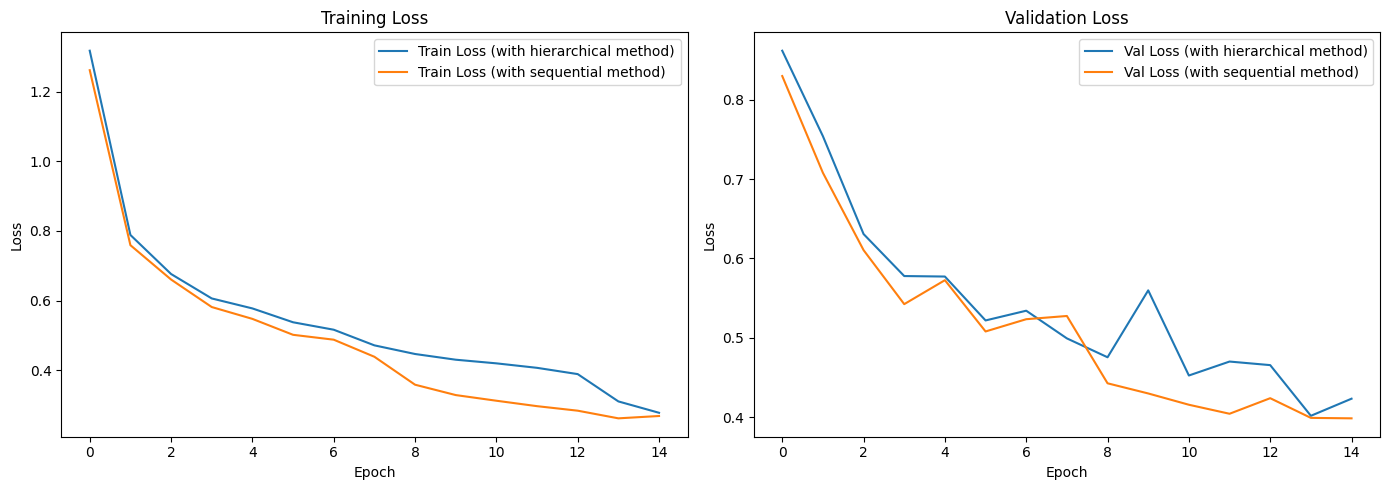

In [2]:
# File paths
root = "data/ModelNet40_PLY"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading datasets + online data augmentation
train_ds = ModelNetDataset(root, folder="train", rotate=True, noise=True)
test_ds = ModelNetDataset(root, folder="test")

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=8, pin_memory=True)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

for norm in [True, False]:
    model_modelnet = CT_Classifier(n_classes=40, model_dim=256, heads=8, num_layers=1,
                                   dropout=0.5, use_scales=True, use_checkpoint=False,
                                   hierarchical=norm, scale_layer_norm=False)
    model_modelnet.to(device)

    _, train_loss, val_loss = train_modelnet40(model_modelnet, device, train_loader,
                                               test_loader, epochs=15, lr=0.001,
                                               weight_decay=0, eval_mode=False,
                                               return_loss_history=True)

    label_suffix = "with hierarchical method" if norm else "with sequential method"

    axs[0].plot(train_loss, label=f"Train Loss ({label_suffix})")
    axs[1].plot(val_loss, label=f"Val Loss ({label_suffix})")

axs[0].set_title("Training Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].set_title("Validation Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()
